## Titanic Passengers Survival Classification

### Objective
To build a classification model to predict whether a passenger survived the sinking of the Titanic, based on attributes of each passenger in the data set.

### About the Data
- The dataset used in this project: 
    - Download from Kaggle
    - https://www.kaggle.com/datasets/abdelrahmansaad10/titanic
    
- We'll be working with the Titanic passenger dataset to build a classification model to predict whether a passenger survied the sinking of the Titanic.  
Here is the data dictionary:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |embark_town| Town of Embarkation|
 |alive  | yes/no  |
 |alone  | yes/no  |


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline and preprocessor
from sklearn.model_selection import train_test_split    
from sklearn.model_selection import GridSearchCV        # to automatically find the best model settings
from sklearn.model_selection import cross_val_score     # to test model reliability on different data chunks
from sklearn.model_selection import StratifiedKFold     # ensures balanced proportions of 'Survived' in folds

from sklearn.preprocessing import StandardScaler        # to scale numbers to a similar range (standardization)
from sklearn.preprocessing import OneHotEncoder         # to turn text into binary numbers (0 or 1)
from sklearn.pipeline import Pipeline                   # to chain preprocessing and modeling steps together
from sklearn.impute import SimpleImputer                # to fill in missing values (NaN) in the data
from sklearn.compose import ColumnTransformer           # to apply different cleaning to different columns
from sklearn.decomposition import PCA                   # to redeuce the numbers features (dimensionality reduction)

# Model
from sklearn.neighbors import KNeighborsClassifier      # model that predicts based on 'similar' neighbors
from sklearn.ensemble import RandomForestClassifier     # powerful model using multiple 'decision trees'
from sklearn.linear_model import LogisticRegression     # classic model for binary (yes/no) classification

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Load the Data

In [2]:
df = pd.read_csv('data/Titanic.csv')
df.head()

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Feature and Target Selection

In [3]:
df.count()

Unnamed: 0     891
survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64

#### Features to drop
`deck` has a lot of missing values so we'll drop it. `age` has quite a few missing values. `embarked` and `embark_town` don't seem relevant so we'll drop them as well.`alive` is not relevant as well so we'll ignore it.

#### Target
`survived` is our target class variable.

In [4]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = df[features]
y = df[target]

#### Handling Imbalance
check for the imbalance in the target

In [5]:
y.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

The counts for not survived is 62%, much higher than survived with 38%,  indicating there are imbalance in the target data

#### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Define preprocessing transformers for numerical and categorical features
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

# Define separate preprocessing pipleines for both feature types
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformed features into single column transformer
# We'll use sklearn "column transformer" estimator to separately transform the features, which will then concatenate the output as a single feature space, ready for input to a ml estimator
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


C:\Users\marya\AppData\Local\Temp\ipykernel_13228\2289890087.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()


### Model Pipeline: Random Forest
Now we complete the model pipeline by combining the preprocessing with a Random Forest Classifier

In [8]:
# Create a Random Forest pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define a parameter grid
# We'll use the grid in a cross validation search to optimize the model
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

#Perform grid search cross-validation (GridSearchCV) and fit the best model to the training data to train the pipeline model
model = GridSearchCV(estimator=pipeline,
                     param_grid=param_grid,
                     cv=cv,
                     scoring='accuracy',
                     verbose=2)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [50, 100]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computat

In [9]:
# Print the best parameters and best cross-validation score
print('\nBest parameters found: ', model.best_params_)
print('Best cross-validation score: {:.2f}'.format(model.best_score_))


Best parameters found:  {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.84


### Evaluate: Random Forest
Get the model predictions from the grid search estimator on the unseen data

In [10]:
# Model prediction
y_pred = model.predict(X_test)

#### Classification Report

In [11]:
# Print classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



#### Confusion Matrix

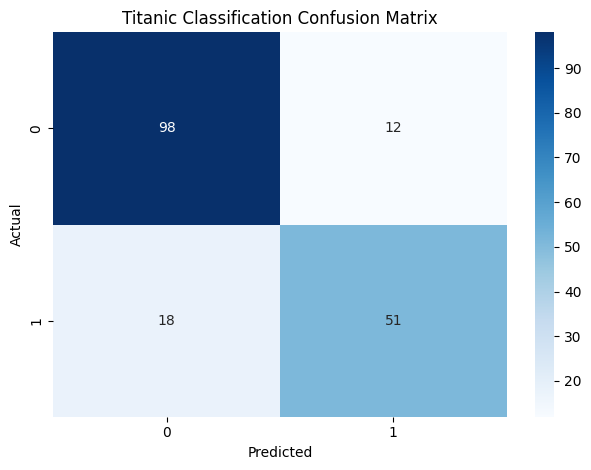

In [12]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


#### Feature Importances

First, to obtain the categorical feature importances, we have to work our way backward through the modeling pipeline to associate the feature importances with their one-hot encoded input features that were transformed from the original categorical features.

We don't need to trace back through the pipeline for the numerical features, because we didn't transfrom them into new ones in any way.  
Remember, we went from categorical features to one-hot encoded features, using the 'cat' column transformer.


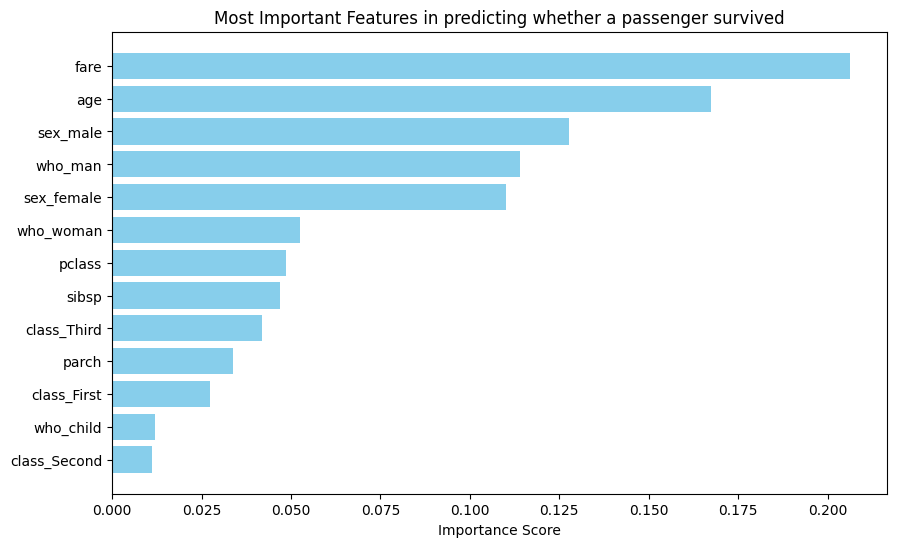


Test set accuracy: 83.24%


In [13]:
# Combined the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(
    model.best_estimator_['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
    )

feature_importances = model.best_estimator_['classifier'].feature_importances_

# Display them in a bar plot
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                              }).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score
test_score = model.score(X_test, y_test)
print(f'\nTest set accuracy: {test_score:.2%}')


The test set accuracy is somewhat satisfactory with 82%. However, regarding the feature importances, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, no doubt there is significant information shared by the variables `age`, `sex_male`, and `who_man`.

### Model Pipeline: Logistic Regression

In [14]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

c:\Users\marya\Downloads\vs code\titanic survival prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\marya\Downloads\vs code\titanic survival prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\marya\Downloads\vs code\titanic survival prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. U

[CV] END classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=balanced, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s


c:\Users\marya\Downloads\vs code\titanic survival prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\marya\Downloads\vs code\titanic survival prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\marya\Downloads\vs code\titanic survival prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. U

#### Classification Report

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



#### Confusion Matrix

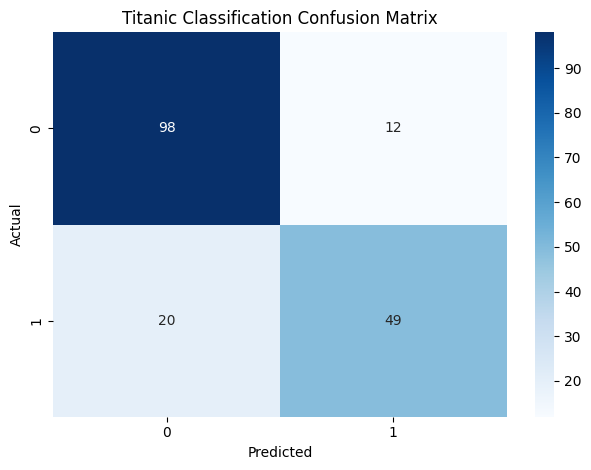

In [16]:
# Generate the confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

#### Feature Importances

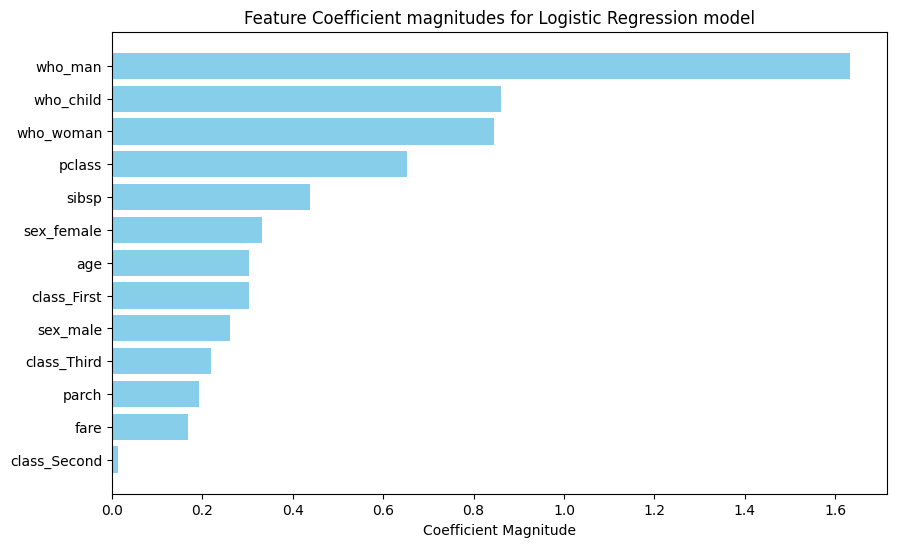


Test set accuracy: 82.12%


In [17]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

### Thoughts

#### 1. Model Performance Comparison
Both RandomForestClassifier and LogisticRegression performed similarly in predicting survived passengers , with RandomForest achieving ~84% accuracy and Logistic Regression achieving ~83% accuracy. However, a deeper analysis of recall and precision shows some key differences:

- RandomForestClassifier has a slightly higher recall (74% vs. 71%) for the "Yes" class (survived), which means it is slightly better at identifying survived passengers.
- Precision for the "Yes" class is slightly higher in RandomForest (81%) compared to Logistic Regression (80%), meaning that when the model predicts survived passengers, it is correct more often.
- Overall, both performance differences are minimal. RandomForest provides a small improvement in recall and precision than Logistic Regression.

#### 2. Further Analysis and Model Improvements
1. Handling Class Imbalance
- The dataset is slightly imbalanced (549 "No" vs. 342 "Yes"), which can lead to biased predictions. 
- Solutions:
    - Oversampling the minority class (SMOTE) to increase "Yes" examples.
    - Using class weights (class_weight='balanced') in models to adjust for the imbalance.

2. Trying More Advanced Models
- Gradient Boosting (XGBoost) can improve predictions by focusing more on misclassified instances.
- Neural Networks could be tested if more data is available.

3. Fine-Tuning Model Hyperparameters
- Performing a Grid Search or Random Search for optimal parameters can boost accuracy.

#### Key Takeawys:
- RandomForestClassifier is the better option as it slightly outperforms Logistic Regression.
- However, both models struggle to correctly predict rain, meaning further optimization is necessary.
- Balancing the dataset, improving feature selection, and testing more advanced models should be the next steps for better accuracy.